In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import math


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, Session, Options


In [54]:
#Rendiamo generale la funzione, prende N numero di Spin, t il tempo, j il primo spin e i il secondo spin (questi saranno j e j+1 in quanto nearest neighbours)
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc


#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

        
        #qc.barrier()

    return qc_t



#La curva esatta

et_steps = 100 #la curva esatta deve essere accurata
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, 3]
et_ts = np.linspace(0, dt, et_steps) 
#011
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in et_ts]


#definiamo il numero di time steps, creiamo ts e definiamo "prj"
t_steps = 12 
#definiamo il tempo in cui facciamo evolvere il sistema
dt = 3
ts = np.linspace(0, dt, t_steps) 

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero


In [58]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="f4017509fb64e20c60312955deef1dbae059e6a54cdea4495c65fc4b00ed1267bfae50397e6bc70fa3ca684494dcb89f98492a91c326ba870afe5120aa3db23d", overwrite= True)

In [59]:
#facciamo andare il circuito con 12 trotter step senza error mitigation
probs_trotter = []
service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False, min_num_qubits=27)
pm_trotter = generate_preset_pass_manager(optimization_level=2, backend=backend)

estimator = Estimator(backend)

estimator.options.resilience_level = 2  # Abilita Zero-Noise Extrapolation (ZNE)


for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato "110"
    qc.x(1)
    qc.x(2)
            
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=12,t=sim_t)
    qc = qc.compose(trott_steps)
        
    isa_circuit = pm_trotter.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
        
    trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
    print(str(trotter_result) + " se è strano sto numero interrompi")
    
    trotter_value = trotter_result[0].data.evs
    probs_trotter.append(trotter_value.mean().real)
    print(str(trotter_value.mean().real) + " se è strano sto numero interrompi")
        
    print("12 steps trotter completed")
print("completed bro")

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>), evs_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), ensemble_stds_noise_factors=np.ndarray(<shape=(3,), dtype=float64>), evs_extrapolated=np.ndarray(<shape=(2, 4), dtype=float64>), stds_extrapolated=np.ndarray(<shape=(2, 4), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {'zne': {'extrapolator': 'multiple'}}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': True, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': True, 'pec

In [60]:
print(str(probs_trotter))

[np.float64(1.0636017602805319), np.float64(0.36845858145781635), np.float64(0.32676772888397165), np.float64(0.15542387632226357), np.float64(0.2299702078385035), np.float64(0.019049333580060654), np.float64(0.150123196441741), np.float64(0.10615844360167499), np.float64(0.19271422259161344), np.float64(0.2318326069669665), np.float64(0.27062883242290037), np.float64(0.5032840446290506)]


In [65]:
#valore assoluto medio
def mae(array1, array2):
    array1 = np.array(array1)
    array2 = np.array(array2)
    mae = np.mean(np.abs(array1 - array2))
    return mae

#valore assoluto medio percentuale
def mae_perc(array1, array2):
    array1 = np.array(array1)
    array2 = np.array(array2)
    mae = np.mean(np.abs(array1 - array2))
    return mae*100

array_exact = [1.0, 0.744, 0.337, 0.224, 0.248, 0.161, 0.117, 0.214, 0.243, 0.238, 0.512, 0.993]
mae_transp = mae(array_exact, probs_trotter)
mae_perc_transp = mae_perc(array_exact, probs_trotter)

print("TRANSPILATION: " + str(mae_transp) + ", " + str(mae_perc_transp) + "%")

TRANSPILATION: 0.13386975653562094, 13.386975653562095%


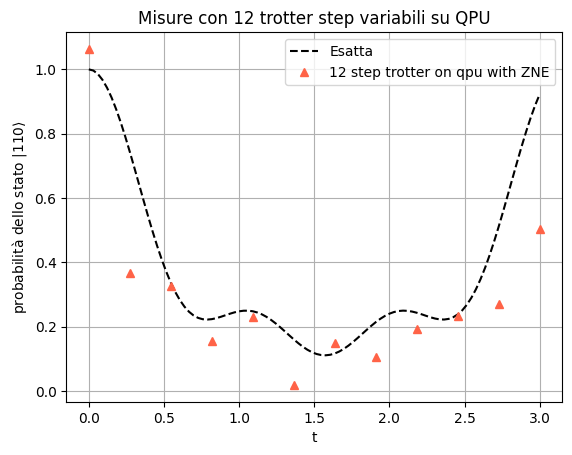

In [67]:
#ibm kiev 127 qubit
plt.plot(et_ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_trotter,'^', color="tomato", label="12 step trotter on qpu with ZNE")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Misure con 12 trotter step variabili su QPU')
plt.legend()
plt.grid()
plt.savefig('../png/qpuZNE.png')
plt.show()